# Problem (case study)

In [1]:
import pandas as pd
import numpy as np

import statistics as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Getting Data & Select Target

In [2]:
data = pd.read_csv('marketing_customer_analysis.txt')

In [3]:
y = data['Total Claim Amount']

# Cleaning/Wrangling/EDA

## Change headers names. Deal with NaN values, replace with appropriate method.

In [4]:
def standardize_header(data):
    cols = []
    for i in range (len(data.columns)):
        cols.append(data.columns[i].lower())
    data.columns = cols

    data.columns = data.columns.str.replace(" ","_")

standardize_header(data)

#once we've fixed the headers, we update our target and remove it from the database
y = data['total_claim_amount']
X = data.drop(['total_claim_amount'],axis=1)

X.head(1)

,unnamed:_0,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,0,DK49336,Arizona,4809.21696,No,Basic,College,2/18/11,Employed,M,...,52,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,NaN


In [5]:
#shows where null values are found
nullvalues = pd.DataFrame(round(X.isna().sum()/len(X),4)*100)
nullvalues = nullvalues.rename(columns={'index':'header',0:'prop_nulls'})
nullvalues

,prop_nulls
unnamed:_0,0.00
customer,0.00
state,5.78
customer_lifetime_value,0.00
response,5.78
coverage,0.00
education,0.00
effective_to_date,0.00
employmentstatus,0.00
gender,0.00


In [6]:
#fill null values of categorical columns with unknown
def fillnull_cate(data,col):
    for i in range (len(col)):
        data[col[i]]=data[col[i]].fillna('unknown')

fillnull_cate(X,['state','response','vehicle_class','vehicle_size','vehicle_type'])   

In [7]:
#fill null values of numerical columns with median
def fillnull_num(data,col):
    for i in range (len(col)):
        data[col[i]]=data[col[i]].fillna(data[col[i]].median())

fillnull_num(X,['months_since_last_claim','number_of_open_complaints'])

In [8]:
# show if there is any null value
X.isnull().values.any()

False

In [9]:
#we eliminate the columns that do not serve us
X=X.drop(['unnamed:_0', 'customer', 'effective_to_date', 'vehicle_type','monthly_premium_auto'],axis=1)
X.head(1)

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,Arizona,4809.21696,No,Basic,College,Employed,M,48029,Suburban,Married,7.0,52,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize


In [10]:
X.columns

Index(['state', 'customer_lifetime_value', 'response', 'coverage', 'education',
       'employmentstatus', 'gender', 'income', 'location_code',
       'marital_status', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'vehicle_class', 'vehicle_size'],
      dtype='object')

## split categorical Features and Numerical Features.

In [11]:
#separete the numerical and categorical features
X_num = X.select_dtypes(include=np.number)
X_cat = X.select_dtypes(include=object)

## Explore visually both sets of features, to identify next steps.

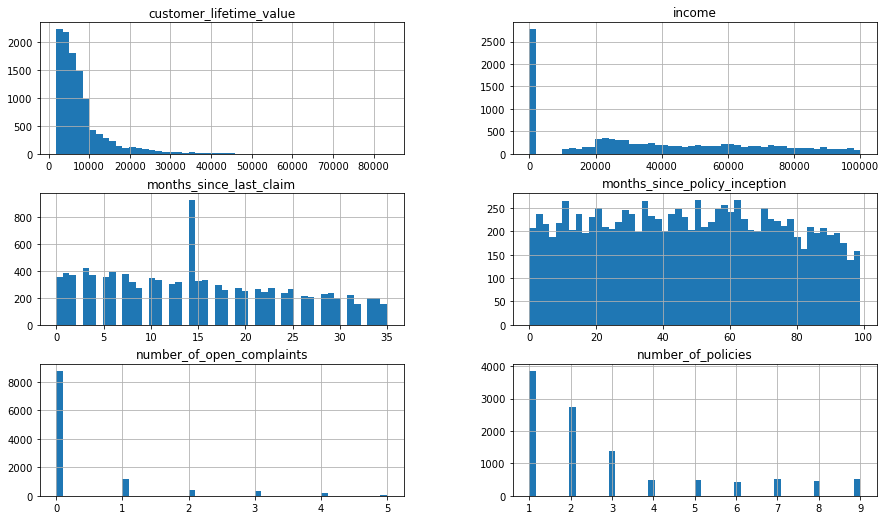

In [12]:
X_num.hist(figsize=(15,15), bins=50, layout=(5,2));

## Look at potential multicollinearity using a correlation matrix or other approach.

In [13]:
matrix=X_num.corr() #will only work for numerical fields
matrix

,customer_lifetime_value,income,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer_lifetime_value,1.000000,0.028306,0.015874,0.016960,-0.030616,0.016024
income,0.028306,1.000000,-0.022708,-0.005903,0.008425,-0.009960
months_since_last_claim,0.015874,-0.022708,1.000000,-0.038157,0.005004,0.006807
months_since_policy_inception,0.016960,-0.005903,-0.038157,1.000000,0.004165,-0.009123
number_of_open_complaints,-0.030616,0.008425,0.005004,0.004165,1.000000,0.001681
number_of_policies,0.016024,-0.009960,0.006807,-0.009123,0.001681,1.000000


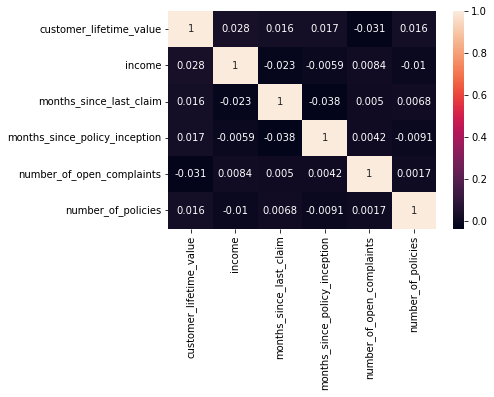

In [14]:
sns.heatmap(matrix, annot=True);

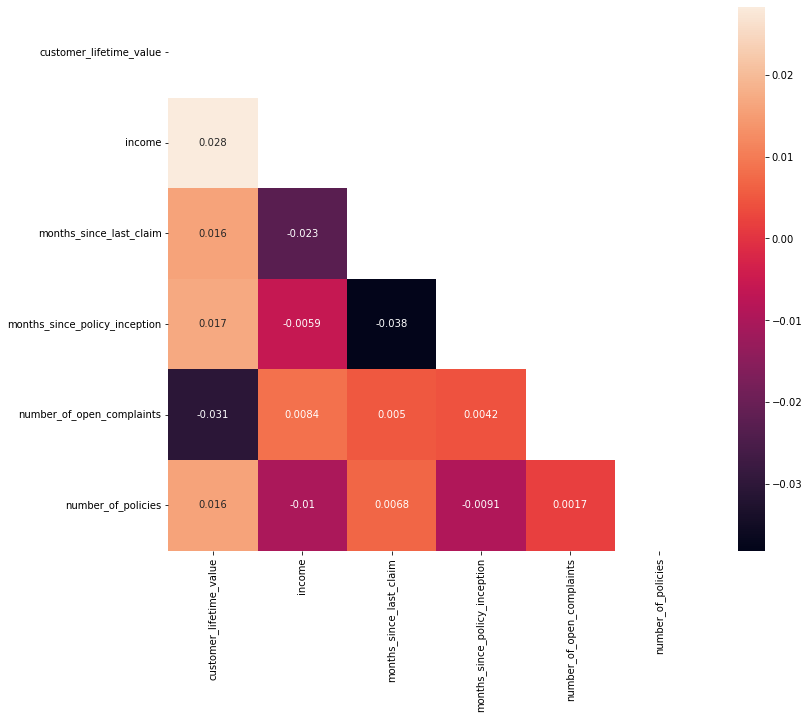

In [15]:
mask=np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax= plt.subplots(figsize=(12,10))
ax= sns.heatmap(matrix, mask=mask, annot=True)

# Pre-Processing Data

## Dealing with outliers. Normalization - ie use chosen scaler to transform selected columns into normal distribution as needed for linear regression model. Propose: MinMax scaler on 'effective_to_date' and standard scaler on numerical columns.

In [16]:
from scipy import stats
X_num[(np.abs(stats.zscore(X_num)) < 3).all(axis=1)]

,customer_lifetime_value,income,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,4809.216960,48029,7.0,52,0.0,9
1,2228.525238,0,3.0,26,0.0,1
2,14947.917300,22139,34.0,31,0.0,2
3,22332.439460,49078,10.0,3,0.0,2
4,9025.067525,23675,14.0,31,0.0,7
...,...,...,...,...,...,...
10904,19228.463620,0,14.0,32,0.0,2
10905,15563.369440,0,14.0,40,0.0,7
10906,5259.444853,61146,7.0,68,0.0,6
10907,23893.304100,39837,11.0,63,0.0,2


## Encoding Categorical Data fields using OHE.

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(handle_unknown='error', drop='first').fit(X_cat)
X_encoded=encoder.transform(X_cat).toarray()
X_encoded


array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [18]:
X_dummies=pd.get_dummies(X_cat, drop_first=True)
X_dummies

,state_California,state_Nevada,state_Oregon,state_Washington,state_unknown,response_Yes,response_unknown,coverage_Extended,coverage_Premium,education_College,...,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_class_unknown,vehicle_size_Medsize,vehicle_size_Small,vehicle_size_unknown
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
10906,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10907,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
10908,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,1,0,0


## Bring categorical and numerical columns back together using pd.concat.

In [19]:
X_final=pd.concat((X_num,X_dummies),axis=1)
X_final

,customer_lifetime_value,income,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,state_California,state_Nevada,state_Oregon,state_Washington,...,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_class_unknown,vehicle_size_Medsize,vehicle_size_Small,vehicle_size_unknown
0,4809.216960,48029,7.0,52,0.0,9,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2228.525238,0,3.0,26,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,14947.917300,22139,34.0,31,0.0,2,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
3,22332.439460,49078,10.0,3,0.0,2,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,9025.067525,23675,14.0,31,0.0,7,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,14.0,40,0.0,7,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
10906,5259.444853,61146,7.0,68,0.0,6,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
10907,23893.304100,39837,11.0,63,0.0,2,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
10908,11971.977650,64195,0.0,27,4.0,6,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


## Splitting into train set and test dataset using random state, eg 80%:20% .

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y,test_size=0.3, random_state=40)

# Modeling

## Apply linear regression model from sklearn.linear_model.

In [21]:
from sklearn import linear_model
lm=linear_model.LinearRegression()
model=lm.fit(X_train,y_train)

## Fit over your train data and predict against X test.

In [22]:
preds=lm.predict(X_test)
preds

array([455.81373349, 839.21331165, 366.70565145, ..., 351.70063702,
       852.0715796 , 557.20613406])

# Model Validation

## You should gather appropriate metrics to evaluate model accuracy over y_test- such as : R2. MSE. RMSE. MAE.

In [23]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#R2
round(r2_score(y_test,preds),4)

0.7422

In [24]:
#MSE
round(mean_squared_error(y_test,preds),4)

22399.9018

In [25]:
#RMSE
round(np.sqrt(mean_squared_error(y_test,preds)),4)

149.666

In [26]:
#MAE
round(mean_absolute_error(y_test, preds),4)

100.4103

# Reporting

## Present results inside your notebook with appropriate annotation describing the accuracy of the model and business insight gained.

Our precision based on the r2_score is 0.7764
The Total Claim Amount we can get based on mean_squared_error is 19427.72

In [27]:
y.shape

(10910,)

In [28]:
preds.shape

(3273,)

In [29]:
preds

array([455.81373349, 839.21331165, 366.70565145, ..., 351.70063702,
       852.0715796 , 557.20613406])

In [30]:
preddata = pd.DataFrame({'Test':preds})

In [31]:
preddata

,Test
0,455.813733
1,839.213312
2,366.705651
3,739.471201
4,476.045166
...,...
3268,592.120544
3269,198.107945
3270,351.700637
3271,852.071580
